## Import main libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from IPython.display import Audio,display


## Basic functions



In [2]:
#Calcul du spectre amplitude et phase du signal x, taille de la fenetre=T, pas=p
def spectrogram(x,T,p):
    wind=0.54-0.46*np.cos(2*np.pi*np.arange(T)/(T-1)) #fenêtre de hamming
    x=(x-np.mean(x))/np.std(x) #normalisation du signal
    S=np.fft.fft(np.array([x[i:i+T] for i in range(0,len(x)-T,p)])*wind) #fenêtrage+fft
    return np.abs(S),np.angle(S)


#Retour du spectrograùùe au domaine temporel à partir de l'amplitude et la phase et le "pas" utilisé
def spectrogram2wav(amp,phase,p):  
    temp=amp*np.exp(1j*phase) #recombiner l'amplitude avec la phase (nombre complexe)
    temp=np.fft.ifft(temp) #retour au domaine temporel par une fft inverse
    temp=np.real(temp) #ne garder que la partie réelle
    
    #fenêtrage inverse
    n,w = amp.shape
    duree=(n-1)*p+w  #estimation de la durée du signal selon le pas et le nombre de fenêtres
    signal=np.zeros(duree)  #initialiser le signal par des zéros 
    trams=np.zeros(duree)  #initialiser le nombre de trames par des zéros 
    for i in range(n):
        signal[i*p:i*p+w]+=temp[i,:]
        trams[i*p:i*p+w]+=1

    signal=signal/trams  #calculer la moyenne du signal à partir des fenêtres qui se recouvrent
    return signal


#Cette fonction affiche un spectrogramme d'amplitude amp
#fs: fréquence d'échantillonnage du signal
def showspectrogram(amp,fs):
    n,T=amp.shape #Nombre de lignes et colonnes de la matrice du spectre
    maxfreq=fs/2 #calcul de la frequence max fs/2 -> effet mirroir
    maxindice=int(T/2) #calcul de l'indice de la frequence max
    S=np.log10(amp.T[:maxindice]+1) #couper le spectre en frequence max et calcul du log
    plt.pcolormesh(np.arange(n), np.linspace(0, maxfreq, maxindice), S, cmap='gray_r')  #afficher le spectre
    plt.ylabel('Fréquence (Hz)')
    plt.xlabel('Temps (sec)')
    plt.grid()
    plt.show()

## Noise cancelling functions


In [3]:

def Energy(amp):
    print(f'amp  : {amp.shape}')
    e=np.mean(amp**2,axis=1)
    print(f'energy  : {e.shape}')


    return e
def NoiseCancelling(amp,threshold=6,alpha = 1):
    energy = Energy(amp)
    silence = amp[energy<threshold]
    print(f'silence: {silence.shape}')
    silence = np.mean(silence,axis=0)
    print(f'silence mean : {silence.shape}')
    amp = amp -silence*alpha
    amp[amp<0]=0
    return amp

### Select file


In [4]:
fs,sgn = read('wavs/Sequence.wav')
print(f'sampling rate : {fs}Hz')
display(Audio(sgn,rate=fs))

sampling rate : 8000Hz


## Transition to the frequency domain and display of the spectrogram

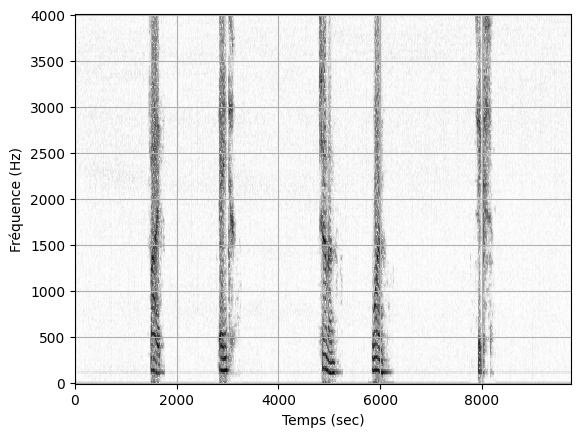

In [5]:
T = 512
p = 16 
amp,ph=spectrogram(sgn,T,p)
showspectrogram(amp,fs)

## return to the time domain using amplitude and phase and listen to the result

In [6]:
new_sgn= spectrogram2wav(amp,ph,p)
display(Audio(new_sgn,rate=fs))


# Speech segmentation 
* Simple mask
* Engine

amp  : (9753, 512)
energy  : (9753,)
silence: (8483, 512)
silence mean : (512,)


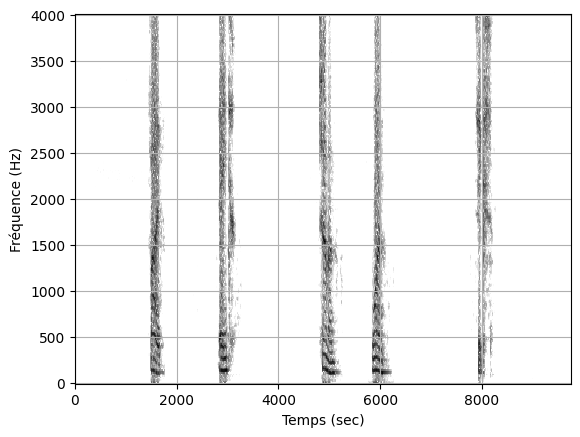

In [7]:
new_sound = NoiseCancelling(amp,threshold=100,alpha=3)
new_amp,new_ph=spectrogram(new_sound,T,p)
showspectrogram(new_sound,fs)
new_sound=spectrogram2wav(new_sound,ph,p)

In [8]:
display(Audio(new_sound,rate=fs))

## Simple mask

In [9]:
new_sound2=new_sound[new_sound != 0]
display(Audio(new_sound2,rate=fs))
len(new_sound),len(new_sound2)


(156544, 79072)

(156559,)


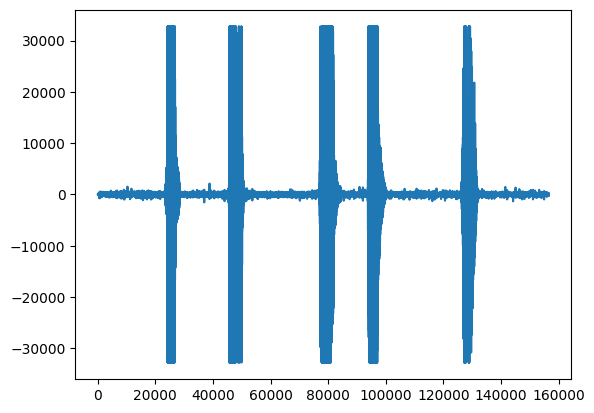

In [10]:
energy = np.power(sgn,2)
plt.plot(sgn[:])
print(sgn.shape)

## Segmentation engine

In [11]:
class Engine():
    def __init__(self,audio,min_threshold):
        self.fs,self.sgn = read(audio)
        self.energy = np.power(self.sgn,2)
        self.B = self._beta_zero()
        self.min_threshold= min_threshold
        self.threshold= self.min_threshold
        self.t_sil = 12000
        self.t_min = 4000
        self.t_max = 110000

    def speech_segmentation(self):
        t=0
        while t < len(self.sgn):
            if energy[t] < self.threshold:
                self.update_threshold(t)
            
            else:
                
                begin_word = t
                t2=t
                cmpt_sil=0
                while (cmpt_sil < self.t_sil ) and (t2 < len(self.sgn))   :
                    # print(f't2 {t2} sgn len {len(self.sgn)}')
                    if energy[t2] > self.threshold:
                        cmpt_sil+=0
                        t
                    else:
                        cmpt_sil+=1
                    t2+=1
                t=t2
                
                end_word = t2 - self.t_sil
                word_duration = end_word - begin_word + 1

                if self.t_min <= word_duration <= self.t_max:
                    self.word_detected(begin_word,end_word)
            t+=1
        return 
    
    def update_threshold(self,t):
        alpha = 0.95
        gamma = 1
        self.B = alpha * self.B + (1-alpha)*self.energy[t]
        self.threshold = (1+gamma)*self.B
        self.threshold = max(self.threshold, self.min_threshold)
        # print(f'threshold: {self.threshold}')
        return 
    
    def _beta_zero(self):
        for t,value in enumerate(self.sgn[:-1]):
            if abs(self.sgn[t]-self.sgn[t+1]) > 10000:
                t0 = t
                print(f't0 : {t0}')
                break
        self.beta_zero = np.sum(self.energy[:t0])/t0
        # print(f'beta_zero : {self.beta_zero}')
        return self.beta_zero
    
    def word_detected(self,begin_word,end_word):
        if round(begin_word/self.fs,1) == 0 : return # ignore beginning of the audio
        print(f'word detected at {begin_word/self.fs}s - {end_word/self.fs}s')
        display(Audio(sgn[begin_word:end_word],rate=fs))
        

sequence contain these words **(Five-eight-seven-one-six)**
min_treshold = 4200 (5-8-1)
min_treshold = 3600 (5-8-7-1)
min_treshold = 3300 (5-8-7-1-6)




In [12]:
Segmenter = Engine(audio='wavs/Sequence.wav',
                   min_threshold=3300)
Segmenter.speech_segmentation()



t0 : 24195
word detected at 3.119s - 4.47675s


word detected at 5.977625s - 7.558s


word detected at 9.058125s - 10.403875s


word detected at 11.904125s - 13.36775s


word detected at 14.868s - 16.34775s
